<a href="https://colab.research.google.com/github/shirinsitara/IMLO/blob/main/IMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [ ]:
from torchvision.datasets import Flowers102

# Load the training data
train_data = Flowers102(root='/flower_data', split='train', download=True, transform=transform)

# Load the validation data
val_data = Flowers102(root='/flower_data', split='val', download=True, transform=transform)

# Load the test data
test_data = Flowers102(root='/flower_data', split='test', download=True, transform=transform)


In [ ]:
train_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /flower_data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
test_data

Dataset Flowers102
    Number of datapoints: 6149
    Root location: /flower_data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
val_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /flower_data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Data Loader
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=False)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
conv1 = nn.Conv2d(3, 64, 3, 2, 2)
conv2 = nn.Conv2d(64, 128, 3, 2, 2)
conv3 = nn.Conv2d(128, 512, 3, 2, 2)
#conv4 = nn.Conv2d(128, 128, 3, 2, 2)

In [ ]:
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [ ]:
X_Train.shape

torch.Size([3, 224, 224])

In [ ]:
x = X_Train.view(1,3,224,224)

In [ ]:
# testign dimensions
x = F.relu(conv1(x))
x = F.max_pool2d(x,2,2,1)
x = F.relu(conv2(x))
x = F.max_pool2d(x,2,2,1)
x = F.relu(conv3(x))
x = F.max_pool2d(x, 2, 2, 1)

In [ ]:
x.shape

torch.Size([1, 512, 5, 5])

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Convoluted Layers
    self.conv1 = nn.Conv2d(3,64,3,2,2)
    self.conv2 = nn.Conv2d(64,128,3,2,2)
    self.conv3 = nn.Conv2d(128,512, 3, 2, 2)
    # Fully Connected Layers
    self.fc1 = nn.Linear(5*5*512, 1200)
    self.fc2 = nn.Linear(1200, 720)
    self.fc3 = nn.Linear(720, 102)

    #Droupouts
    self.dropout_conv = nn.Dropout2d(0.25)  # for convolutional layers
    self.dropout_fc = nn.Dropout(0.5)   # for fully connected layers


  def forward(self, X):
    # First layer
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2, 1)

    #Second layer
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2, 1)

    # Third layer
    X = F.relu(self.conv3(X))
    X = self.dropout_conv(X)
    X = F.max_pool2d(X, 2, 2, 1)

    # Re-View to flatten it out
    X = X.view(-1, 512*5*5)

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=12800, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=720, bias=True)
  (fc3): Linear(in_features=720, out_features=102, bias=True)
  (dropout_conv): Dropout2d(p=0.25, inplace=False)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 50
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Updating parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    # if b%10 == 0:
    #   print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(val_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

  train_accuracy = trn_corr / len(train_loader.dataset) * 100
  test_accuracy = tst_corr / len(val_loader.dataset) * 100

  print(f'Epoch {i+1} - Training Accuracy: {train_accuracy:.2f}% - Validation Accuracy: {test_accuracy:.2f}%')



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1 - Training Accuracy: 0.49% - Validation Accuracy: 0.98%
Epoch 2 - Training Accuracy: 0.69% - Validation Accuracy: 0.98%
Epoch 3 - Training Accuracy: 0.49% - Validation Accuracy: 0.98%
Epoch 4 - Training Accuracy: 0.59% - Validation Accuracy: 0.98%
Epoch 5 - Training Accuracy: 0.69% - Validation Accuracy: 1.96%
Epoch 6 - Training Accuracy: 1.76% - Validation Accuracy: 2.65%
Epoch 7 - Training Accuracy: 1.76% - Validation Accuracy: 2.65%
Epoch 8 - Training Accuracy: 1.67% - Validation Accuracy: 3.33%
Epoch 9 - Training Accuracy: 1.96% - Validation Accuracy: 2.16%
Epoch 10 - Training Accuracy: 3.53% - Validation Accuracy: 4.02%
Epoch 11 - Training Accuracy: 3.43% - Validation Accuracy: 4.31%
Epoch 12 - Training Accuracy: 5.29% - Validation Accuracy: 4.02%
Epoch 13 - Training Accuracy: 5.59% - Validation Accuracy: 6.18%
Epoch 14 - Training Accuracy: 5.88% - Validation Accuracy: 7.25%
Epoch 15 - Training Accuracy: 7.84% - Validation Accuracy: 8.24%
Epoch 16 - Training Accuracy: 9.22

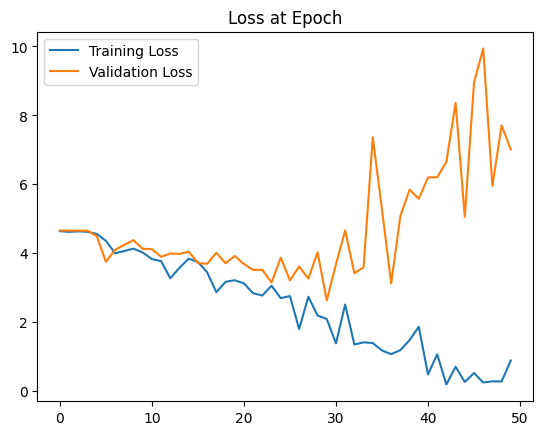

In [ ]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

In [ ]:

check_test_losses = []
check_test_correct = []

check_correct = 0

# Test
with torch.no_grad():
  for b,(X_test, y_test) in enumerate(test_loader):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    check_correct += (predicted == y_test).sum()

loss = criterion(y_val, y_test)
check_test_losses.append(loss)
check_test_correct.append(check_correct)


check_test_accuracy = tst_corr / len(val_loader.dataset) * 100

print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 12.84%


In [ ]:
# # to download the module uncomment the following code and add your path
# import os
# save_directory = r'add/your/path'
# os.makedirs(save_directory, exist_ok=True)
# save_path = os.path.join(save_directory, 'model.pth')

# # Save the model
# torch.save(model.state_dict(), save_path)